# Machine Learning

## Key concepts

1. Overfitting
2. Evaluation metrics: accuracy, precision, recall
3. Two learning paradigms
4. Moons and circles
5. Handwriting recognition and more

*Side note for today:* no exercises in-class, but rather DIY exercises on your own. Instead, we will spend 1/2 time on lecture, 1/2 time thinking about project ideas.


## 1. Overfitting

Previous goals involved **making inferences** from the data:

* summarizing patterns (identifying the empirical distribution);
* checking beliefs against observations (testing a hypothesis);
* specifying explanatory variables (fitting a linear regression).

Today's goal involves **learning models** from the data; i.e., computing a relationship in the data that will generalize to new settings.

*Discuss:*

* How can we learn?
* How can we measure how well a "learned" relationship will generalize?

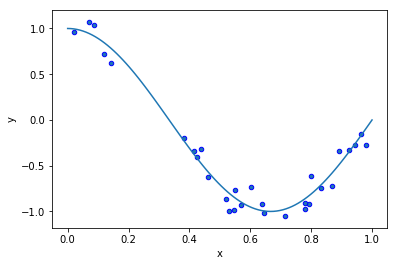

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

N_SAMPLES = 30

def true_foo(X):
    return np.cos(1.5 * np.pi * X)
  
np.random.seed(0)
X = np.random.rand(N_SAMPLES)
y = true_foo(X) + np.random.randn(N_SAMPLES) * 0.1
X_test = np.linspace(0, 1, 100)

plt.plot(X_test, true_foo(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

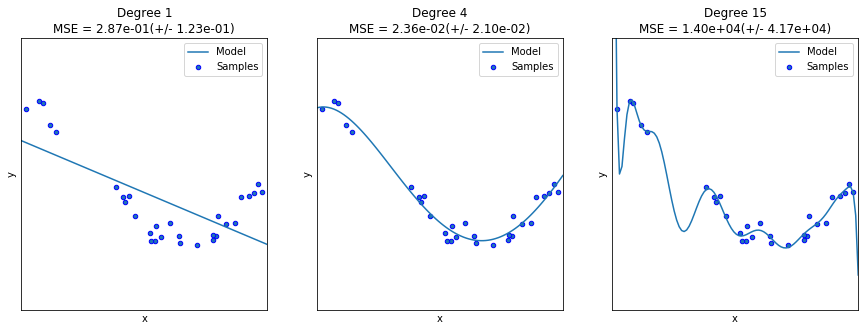

In [5]:
# Fit the samples with different polynomial degrees
degrees = [1, 4, 15]

plt.figure(figsize=(15, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(
        degree=degrees[i],
        include_bias=False,
    )
    linear_regression = LinearRegression()
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression)
    ])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, 
        X[:, np.newaxis], 
        y,
        scoring="neg_mean_squared_error", 
        cv=10,
    )

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], 
        -scores.mean(), 
        scores.std(),
    ))
    
plt.show()

### A note on cross-validation

![k-folds](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

*Discuss:* What is the effect of changing $k$ in the $k$-fold cross-validation depicted above?Dis

## 2. Evaluation metrics

Previously, you learned about **sum of squared errors** as a loss,

$$ \text{squared error loss} = \frac{1}{N} \sum_{i=1}^N (\text{predicted}_i - \text{actual}_i)^2,$$

which describes: *how far are my predictions from the truth, on average?*

When dealing with discrete data, sometimes you will prefer other evaluation metrics. Suppose your $\text{actual}$ labels can be either $+1$ or $-1$. Predictions can then be:

![confusion matrix](https://cdn-images-1.medium.com/max/1600/1*OhEnS-T54Cz0YSTl_c3Dwg.jpeg)

Some example evaluation metrics are: **accuracy**, which measures *how correct are my predictions?*,

$$\text{accuracy} := \frac{\#\{\text{true positive or true negative}\}}{\#\{\text{predicted}\}},$$


or **precision**, which measures *of my positive predictions, how many did I classify correctly?*,

$$\text{precision} := \frac{\#\{\text{true positive}\}}{\#\{\text{predicted positive}\}},$$

or **recall**, which measures *of all positive data points, how many did I classify correctly?*

$$\text{recall} := \frac{\#\{\text{true positive}\}}{\#\{\text{actual positive}\}}.$$

*Discuss:* When might precision matter more than recall, or vice versa?

*DIY later:* given vector of predicted and actual classes, compute the metrics above.


In [0]:
import numpy as np

example_actual = np.array([-1, -1, -1, 1, ])
example_predicted = np.array([-1, 1, 1, -1, -1])

def evaluate(actual: np.array, predicted: np.array, metric: str):
  if metric == 'squared':
    pass  # do this later!
  
  elif metric == 'accuracy':
    pass  # do this later!
    
  elif metric == 'precision':
    pass  # do this later!
    
  elif metric == 'recall':
    pass  # do this later!
    
  else:
    raise NotImplementedError("Not yet implemented!")

## 3. Two learning paradigms


* **Extrapolate:** discover some underlying structure in the data, and use this structure to create simple rules from which to extrapolate predictions for new settings.
* **Memorize:** record all data, and when faced with a new setting, find the old data most similar to the new data, and use that old data as a blueprint for prediction.



### Extrapolate: logistic regression

Consider the relationship of tumor size (our $X$ variable) and malignancy (a binary $Y$ label). *Linearity* is one example of underlying structure that we can use here.

In the continuous setting, you have seen *linear regression* -- as $X$ changes, the value of the label $Y$ is expected to change by $X^T\beta$.

$$ \mathbb{E}[Y | X] = X^T\beta.$$

In the discrete setting (e.g., the binary $+1$ vs. $-1$ above), the analog is *logistic regression* -- as $X$ changes, the _logarithm of the probability_ that the label $Y$ equals $+1$ increases by $X^T\beta$.
$$\log \mathbb{P}(Y = +1 \, |\, X) = X^T\beta.$$

![Tumor size vs. malignancy](http://www.holehouse.org/mlclass/06_Logistic_Regression_files/Image.png)

Ultimately, we want classifications, not log-probabilities -- to do so, pick some threshold, and above it classify as $+1$, below it classify as $-1$. The threshold can be shifted up and down in order to get the best evaluation metric of your choice (e.g., accuracy, recall, precision).

*Discuss:* You know about the assumptions baked into linear regression -- what about logistic regression?

### Memorize: k-nearest neighbors

Suppose we need to determine whether a datapoint is of type A or type B – e.g., we have demographic information for an individual and we want to guess whether they are a Republican or a Democrat. 

1.	Choose a positive integer $k$, say $k=3$.
2.	Choose a distance metric `dist` – e.g., Euclidean distance.
3.	For given datapoint $i$, assign $i$ the classification of the majority of its $k$ nearest neighbors, where "nearest" is with respect to `dist`.

*Discuss:* How would we use cross-validation with this algorithm? 

*Discuss:* What are some problems with low values of $k$? How about high values of $k$? 


## 4. Moons and circles

In [0]:
# TODO: apply both examples to moons and circles
# save the two for exercises: mnist (but discuss in class), unsupervised
# more discussion in extrapolation / memorization

In [0]:
# Train logistic regression using the sklean tool

logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

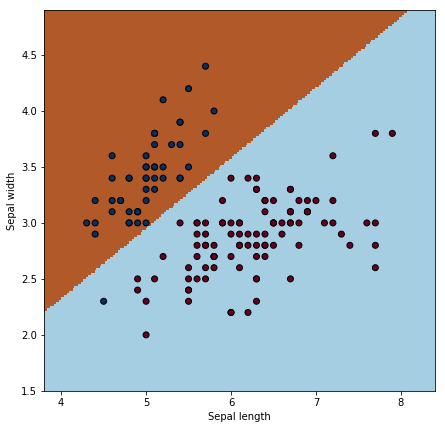

In [0]:


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])


# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(7, 7))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=np.reshape(Y, (len(Y))), edgecolors='k', cmap='RdBu')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

In [0]:
# Print the trained weights and intercept
print (logreg.coef_)
print (logreg.intercept_)

[[-2.19848683  3.49704579]]
[ 0.67817361]


In [0]:
# Evaluate the model on test data

predict = logreg.predict(x_test)

print(metrics.classification_report(y_test, predict))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predict))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00        26
          1       1.00      1.00      1.00        19

avg / total       1.00      1.00      1.00        45

Confusion matrix:
[[26  0]
 [ 0 19]]


<div style="border: 3px solid green; padding: 10px">
<b>Exercise 3:</b> Try to use the features 'petal_length' and 'petal_width' to predict whether an iris flower is setosa, and try to check which features are better. 
</div>

Hand-written Digits Recognition
------------

In [0]:

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

print (len(digits.images))
print (len(digits.target))

images_and_labels = list(zip(digits.images, digits.target))
print (images_and_labels[0])

1797
1797
(array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]]), 0)


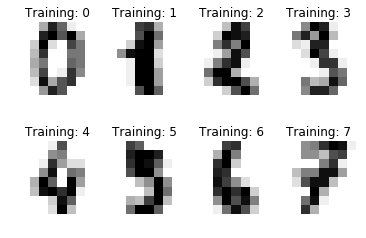

In [0]:
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.

for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Training: %i' % label)
    
plt.show()

In [0]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
print (data[0])

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]


In [0]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)



<img src="../images/svm.png",width=400,height=400>


In [0]:

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.99      0.99        88
          1       0.99      0.97      0.98        91
          2       0.99      0.99      0.99        86
          3       0.98      0.87      0.92        91
          4       0.99      0.96      0.97        92
          5       0.95      0.97      0.96        91
          6       0.99      0.99      0.99        91
          7       0.96      0.99      0.97        89
          8       0.94      1.00      0.97        88
          9       0.93      0.98      0.95        92

avg / total       0.97      0.97      0.97       899


Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1 

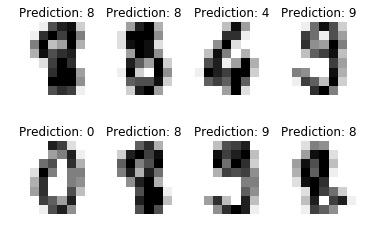

In [0]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Prediction: %i' % prediction)

plt.show()


In [0]:
# Part of the code is borrowed from 
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
